# Final Project for Machine Learning Introduction Course

## Problem Description
For my final project of the Coursera's Machine Learning Introduction course I chose to work on the Kaggle's "Bag of Words Meets Bags of Popcorn" competition as it combines two of my main hobbies: data science and movies. 

The competition's main focus is to perform a sentiment analysis on a labeled data set consisting of 50,000 IMDB movie reviews. The sentiment of reviews is binary; if the IMDB rating is less than 5, the sentiment score will be "0" and if the rating is more than or equal to 7, the score will be "1". For training, there's a labeled data set containing 25,000 items and does not include any of the same movies as the 25,000 review test set. Data can be found in here : https://www.kaggle.com/competitions/word2vec-nlp-tutorial/data

I'll start first with an exploratory daya analysis. Then, I'll load and clean the movie reviews to apply a Natural Language Processing (NLP) model called "Bag of Words" (which I'll describe in more detail in the Model section) combined with the application of a Random Forest to predict wether a review is good or bad.

The following cell imports all the required libraries for this project.



In [7]:
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup 
import zipfile
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS


The first step is to load and read the training data set containing 25k reviews from IMDB with positive and negative sentiment labels. This is a file that has 3 columns named : "id" , "sentiment" and "review".

In [3]:
zf = zipfile.ZipFile('/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip') 
train = pd.read_csv(zf.open('labeledTrainData.tsv'), header=0, \
                    delimiter="\t", quoting=3)

train.shape


(25000, 3)

In [4]:
train.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

## Exploratory Data Analysis (EDA)

Once I was able to load and read the data, I proceeded to do an exploratory data analysis (EDA) with the objective of understading completely the data that we have before applying the DL model that best suits to this problem. First, as stated above, the dataset is comprised of 25,000 rows and 3 columns. I'll print a review example to see how does it look like. The reviews contain HTML tags like " ", abbreviationns and punctuations, which will be removed to avoid issues while processing the texts.

In [8]:
print('Dimension of Labeled Training Dataset: {}.'.format(train.shape))
print('There are {0} samples and {1} variables in the training data.'.format(train.shape[0], train.shape[1]))

Dimension of Labeled Training Dataset: (25000, 3).
There are 25000 samples and 3 variables in the training data.


In [5]:
print(train["review"][5])


"I dont know why people think this is such a bad movie. Its got a pretty good plot, some good action, and the change of location for Harry does not hurt either. Sure some of its offensive and gratuitous but this is not the only movie like that. Eastwood is in good form as Dirty Harry, and I liked Pat Hingle in this movie as the small town cop. If you liked DIRTY HARRY, then you should see this one, its a lot better than THE DEAD POOL. 4/5"


With the following cell, I can get a quick look of the first five items from the data set confirming how each review gets its binary classification and also realizing that there's an equal distribution of positive and negative reviews with 12,500 items each.

In [9]:
display(train.head())
print ("Number of Positive reviews: {}".format(len(train[train.sentiment == 1])))
print ( "Number of Negative reviews: {}".format(len(train[train.sentiment == 0])))

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


Number of Positive reviews: 12500
Number of Negative reviews: 12500


As a next step, I'll get a couple of plots to complete the data exploration through visualizations. The first one is a histogram that shows the count of letters in the reviews. In order to do that, I first create a column in the data set containing the length of each review and then generate the plot. In average, the reviews contain ~ 1,300 letters.

In [11]:
train['length'] = train['review'].apply(len)
train.head()


,id,sentiment,review,length
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",2304
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",948
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",2451
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",2247
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",2233


<AxesSubplot:ylabel='Frequency'>

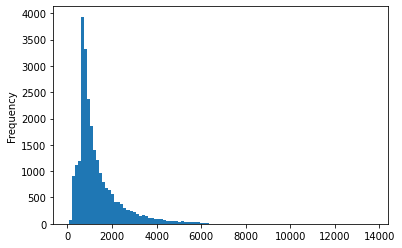

In [12]:
train['length'].plot.hist(bins = 100)

Then, I'll generate a word clustering through WordCloud before cleaning the dataset to see which words repeat more. Some examples of these words are:  "film", "br" and "story" .

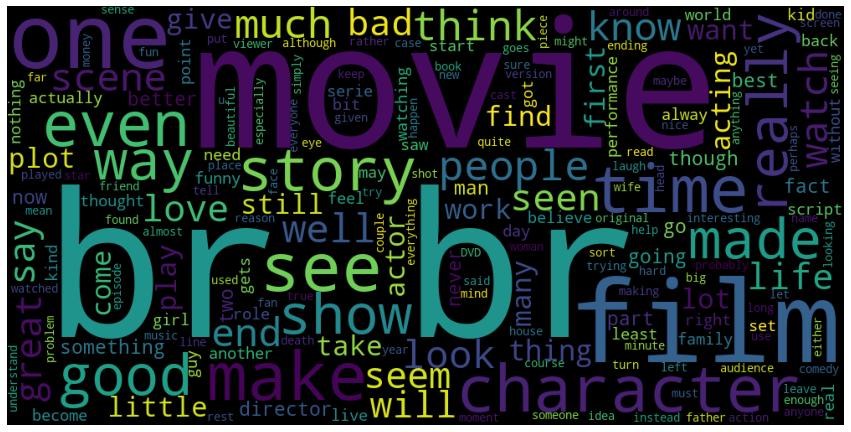

In [13]:
#Plot wordcloud
cloud = WordCloud(width = 1000, height = 500, stopwords = STOPWORDS, background_color = 'black').generate(
                        ''.join(train['review']))

plt.figure(figsize = (15,8))
plt.imshow(cloud)
plt.axis('off')
plt.show()


After understanding the data, my next step was to clean it and process it. I used the package "Beautiful Soup" to revome the HTML tags mentioned above. Beautiful Soup is a python library that provide ways to navigate, search and modify the parse tree.

The following cell provides an example of how the library gives the review without tags or markup. 

In [5]:
example1 = BeautifulSoup(train["review"][5])
print(example1.get_text())

"I dont know why people think this is such a bad movie. Its got a pretty good plot, some good action, and the change of location for Harry does not hurt either. Sure some of its offensive and gratuitous but this is not the only movie like that. Eastwood is in good form as Dirty Harry, and I liked Pat Hingle in this movie as the small town cop. If you liked DIRTY HARRY, then you should see this one, its a lot better than THE DEAD POOL. 4/5"


Before I start creating the model, I needed to complete the cleaning process. Therefore, the following function performs several steps to remove elements that are not required and converts the raw review into a string of words. 

It first starts by removing the HTML tags, then removes the non-letters items. The third step converts all to lower case and split them into individual words. Next, the items are converted into a set as in Python is faster to search in a set rather than just searching. Finally, all the stop words are removed (which are words that do not carry much meaning such as "a", "the", is") and the remaining words are joined into a paragraph so the output is easier to use in the Bag of Words. The cell following to the one that defines a function shows an example of the output that we would have after using the function in a review.

In [8]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
        # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. Convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    return( " ".join( meaningful_words ))   

In [9]:
clean_review = review_to_words( train["review"][5] )
print(clean_review)

dont know people think bad movie got pretty good plot good action change location harry hurt either sure offensive gratuitous movie like eastwood good form dirty harry liked pat hingle movie small town cop liked dirty harry see one lot better dead pool


Once it is confirmed that the function is working properly, I put inside a loop to clean ALL the training dataset. The output of the cell will be the list of the reviews cleaned up. 

In [10]:
# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size

# Initialize an empty list to hold the clean reviews
print ("Cleaning and parsing the training set movie reviews...\n")
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in range( 0, num_reviews ):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    if( (i+1)%1000 == 0 ):
        print("Review %d of %d\n" % ( i+1, num_reviews ))
    clean_train_reviews.append( review_to_words( train["review"][i] ) )
    

Cleaning and parsing the training set movie reviews...



/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


Review 1000 of 25000

Review 2000 of 25000

Review 3000 of 25000

Review 4000 of 25000

Review 5000 of 25000

Review 6000 of 25000

Review 7000 of 25000

Review 8000 of 25000

Review 9000 of 25000

Review 10000 of 25000

Review 11000 of 25000

Review 12000 of 25000

Review 13000 of 25000

Review 14000 of 25000

Review 15000 of 25000

Review 16000 of 25000

Review 17000 of 25000

Review 18000 of 25000

Review 19000 of 25000

Review 20000 of 25000

Review 21000 of 25000

Review 22000 of 25000

Review 23000 of 25000

Review 24000 of 25000

Review 25000 of 25000



## Model Building

Once the dataset is in the required format, we can build the model. The first step is to transform the training reviews  in a numeric representation by creating a Bag of Words. This model will learn a vocabulary from all documents, then it generates a model of each document by counting the number each word appears. 

As the training dataset has a large number of reviews, I limited the number of feature vectors to the 5000 most frequent words. 

The bag of words is created with the "feature_extraction" module from scikit-learn.

Once the bag of words gets created, I want to know the size of the training array, which will be 25,000 rows and 5,000 features (one for each vocabulary word).

In [11]:
print ("Creating the bag of words...\n")
# Initialize the "CountVectorizer" object
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)
train_data_features = train_data_features.toarray()
print (train_data_features.shape)

Creating the bag of words...

(25000, 5000)


## Training 

After creating the Bag of Words I'll create a Random Forest, which is included in the scikit-learn toolkit,  to do a supervised learning. I decided to create only 200 trees or estimators due to processing limitations but this is an important paramenter that can be modified to improve the model's accuracy.

The forest is fitted to the training set using the bag of words as features and the sentiment labels as the response variable.

In the end, the cell computes the training error which in our case is 0.151.

In [12]:
print("Training the random forest...")
forest = RandomForestClassifier(n_estimators = 200) 
forest = forest.fit( train_data_features, train["sentiment"] )

forest_error = 1 - cross_val_score(forest, train_data_features, train['sentiment'], 
                                   cv=5, scoring='accuracy', n_jobs=-1).mean()
print('Random Forest training error: {:.4}'.format(forest_error))

Training the random forest...
Random Forest training error: 0.151


## Results

After the training is finished, the last step is to perform the predictions and create the file with the results for submission.

For the predictions I used the test dataset which contains another 25,000 reviews. 

The code creates an empty list and adds the clean reviews one by one. Then it gets a bag of words for the test set and coverts it into an array. Next it uses the random forest to preform the sentiment label predictions so in the end the results get copied into a new dataframe with two columns : "id" and "sentiment".

The model got a score in the competition of 0.85268 which is not bad for my educational purposes.

In [13]:
zf_test = zipfile.ZipFile('/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip') 
test = pd.read_csv(zf_test.open('testData.tsv'), header=0, \
                    delimiter="\t", quoting=3)

print(test.shape)
num_reviews = len(test["review"])
clean_test_reviews = [] 

print("Cleaning and parsing the test set movie reviews...\n")
for i in range(0,num_reviews):
    if( (i+1) % 1000 == 0 ):
        print("Review %d of %d\n" % (i+1, num_reviews))
    clean_review = review_to_words( test["review"][i] )
    clean_test_reviews.append( clean_review )


test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()


result = forest.predict(test_data_features)

output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

output.to_csv( "Bag_of_Words_model.csv", index=False, quoting=3 )

(25000, 2)
Cleaning and parsing the test set movie reviews...



/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


Review 1000 of 25000

Review 2000 of 25000

Review 3000 of 25000

Review 4000 of 25000

Review 5000 of 25000

Review 6000 of 25000

Review 7000 of 25000

Review 8000 of 25000

Review 9000 of 25000

Review 10000 of 25000

Review 11000 of 25000

Review 12000 of 25000

Review 13000 of 25000

Review 14000 of 25000

Review 15000 of 25000

Review 16000 of 25000

Review 17000 of 25000

Review 18000 of 25000

Review 19000 of 25000

Review 20000 of 25000

Review 21000 of 25000

Review 22000 of 25000

Review 23000 of 25000

Review 24000 of 25000

Review 25000 of 25000



## Conclusion

I made this project following Kaggle's tutorial "Part 1 For Beginners Bag of Words" (link can be found in the References section) as I'm getting started in the world of programming and data science. 

After learning various Machine Learning techniques through the course, this work allowed me to get familiar with a different bagging approach(Bag of Words) and apply it to something I really enjoy and do a lot : read movie reviews from IMDB.

With the tutorial it was pretty simple to create the model and get good prediction results. I understood that in order to improve its performance I can clean the reviews in a different way, use different number of vocabulary words, apply a different classifier or include a stemming process.

As a next step, I will use this dataset but now applying Word Vectors techniques.

## References
* Bag of Words Meets Bags of Popcorn. Kaggle. https://www.kaggle.com/competitions/word2vec-nlp-tutorial/overview/part-1-for-beginners-bag-of-words
* Bag of Words Model. Wikipedia. https://en.wikipedia.org/wiki/Bag-of-words_model
* Bag of Words Meets Bag of Popcorn. Github. https://github.com/ParveshDhawan/Bag-of-Words-Meets-Bags-of-Popcorn/blob/master/solution.ipynb
* Beatiful Soup Documentation. Crummy. https://www.crummy.com/software/BeautifulSoup/bs4/doc/